# Plot PCs vs covariates  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%reload_ext version_information
%version_information

Software versions
Python 2.7.12 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 2.6.32 431.3.1.el6.x86_64 x86_64 with centos 6.8 Final
Thu Jan 05 23:02:29 2017 EST

# Setup

In [2]:
# Input files
PDATA = "../data/pData.pickle"
MAPPED_PC = "../data/samples_x_mapped_PCs.tsv"

# Load PC and phenotype data

In [3]:
pData = pd.read_pickle(PDATA)
pData.shape

(8525, 207)

In [4]:
pcData = pd.read_table(MAPPED_PC, index_col=0)
pcData.shape

(8525, 10)

In [5]:
df = pd.concat([pcData, pData], axis=1)
df.shape

(8525, 217)

# Def: Plot PC vs covariates

In [13]:
def plot_pc_vs_covariate(df, tissue, pc, covar, hue=None, style='darkgrid', rotate=False,  fit_reg=True):
    sns.set(style=style, font_scale=1.1)
    subdf = df[df.SMTS == tissue]
    
    if hue:
        subdf[hue].cat.remove_unused_categories(inplace=True)
    else:
        hue = None
    
    if subdf[covar].dtype.name == 'category':
        subdf[covar].cat.remove_unused_categories(inplace=True)
        n_categories = len(subdf[covar].cat.categories)
        if n_categories < 15:
            figsize = (1.2 * n_categories, 4)
            plt.figure(figsize=figsize)
            sns.boxplot(x=covar, y=pc, data=subdf, color='white', width=0.6)
            sns.swarmplot(x=covar, y=pc, hue=hue, data=subdf, alpha=.8, size=3)
            if hue:
                plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), fontsize=8)
        else:
            sns.stripplot(x=covar, y=pc, hue=hue, data=subdf)
            labels = plt.gca().get_xticklabels()
            plt.setp(labels, fontsize=6)
    else:
        sns.lmplot(x=covar, y=pc, hue=hue, data=subdf, fit_reg=fit_reg)
    
    plt.title(tissue)
    if rotate:
        labels = plt.gca().get_xticklabels()
        plt.setp(labels, rotation=90)

# Interactive plotter

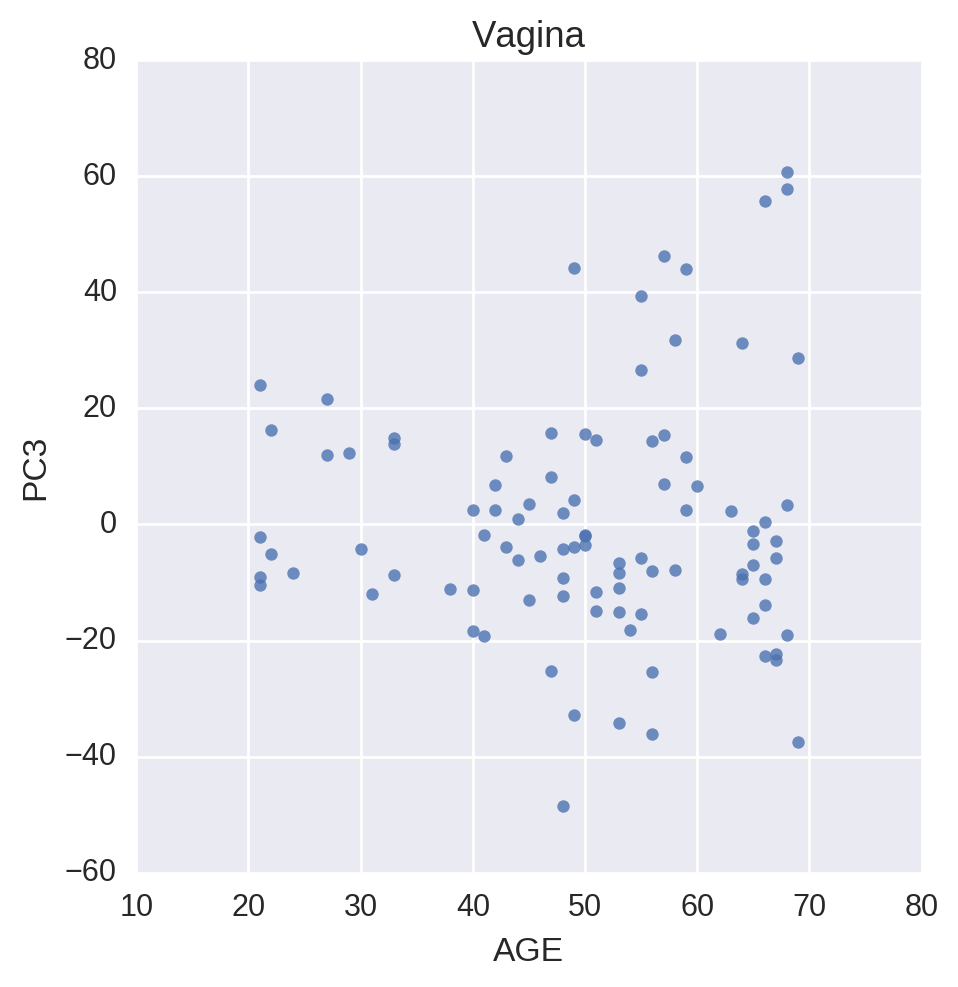

In [7]:
from ipywidgets import interact, fixed

tissues = df.SMTS.cat.categories.tolist()
variables = [None] + df.columns.tolist()
interact(plot_pc_vs_covariate, df=fixed(df), tissue=tissues, pc='PC1', covar='AGE', hue='', style=fixed('darkgrid'), rotate=False, fit_reg=True, __manual=True)

# Gallery

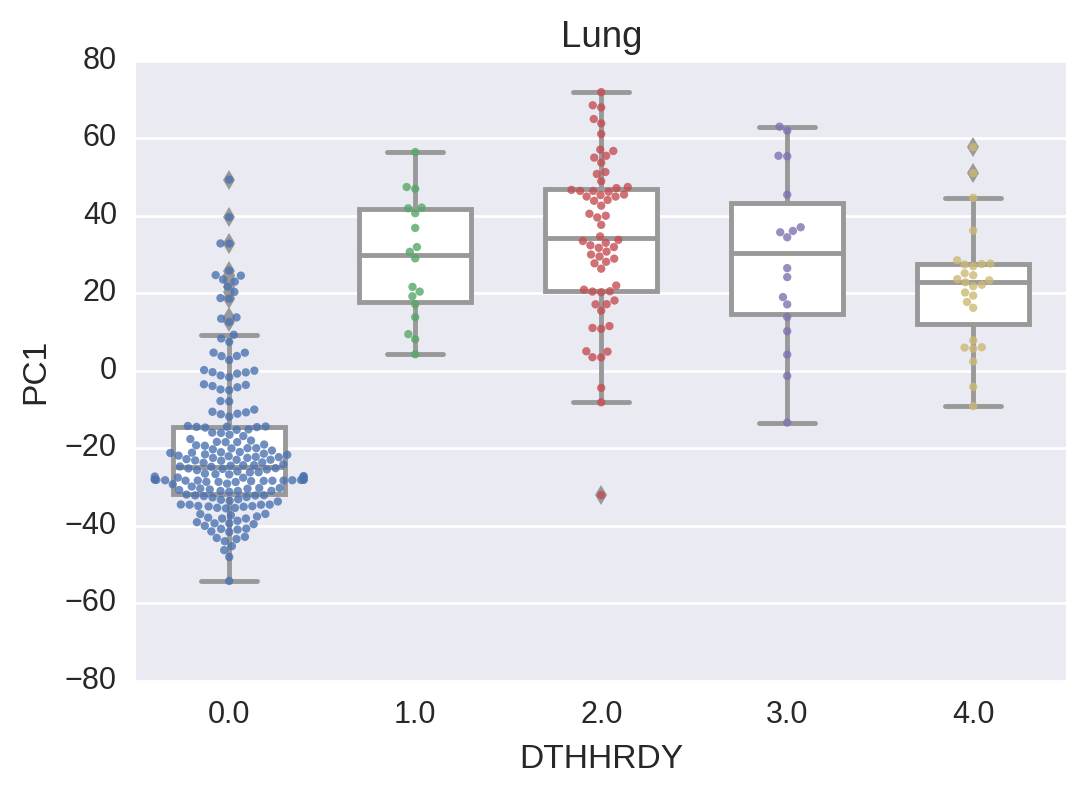

In [8]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHHRDY')

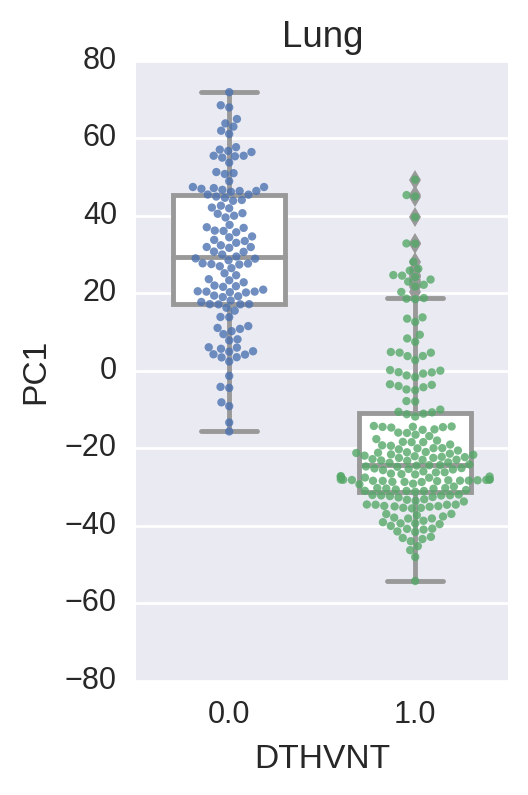

In [9]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHVNT')

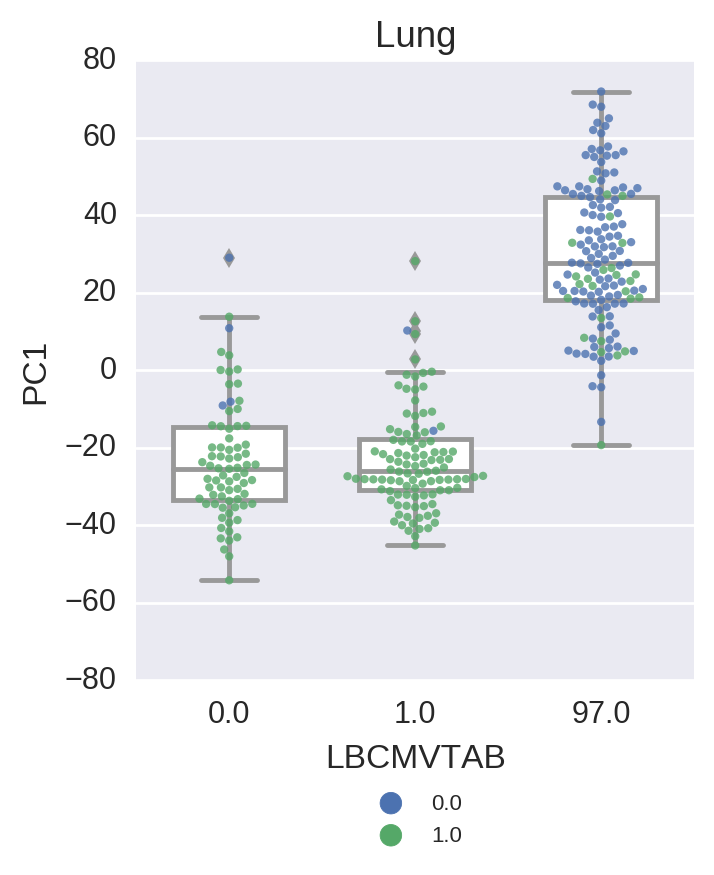

In [10]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'LBCMVTAB', hue='DTHVNT')

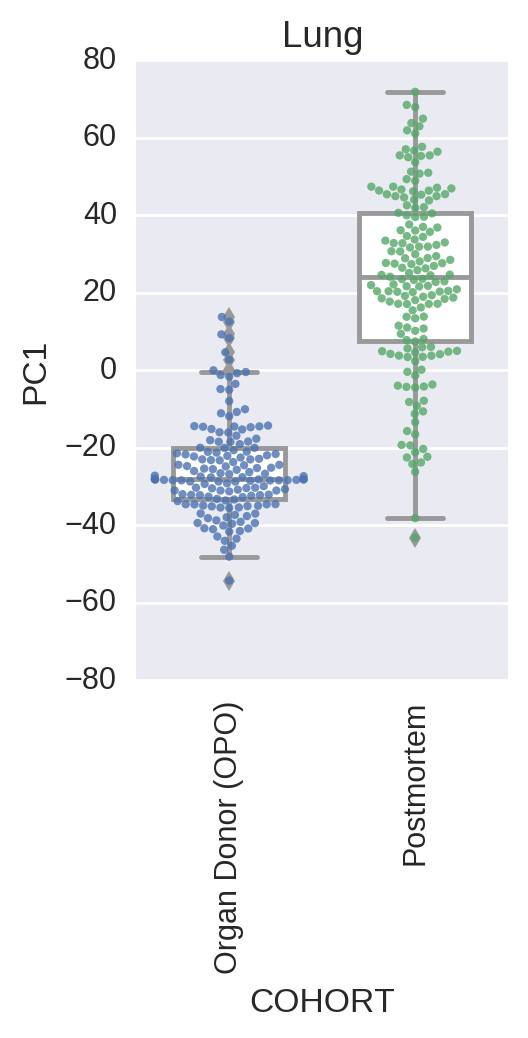

In [11]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'COHORT', rotate=True)

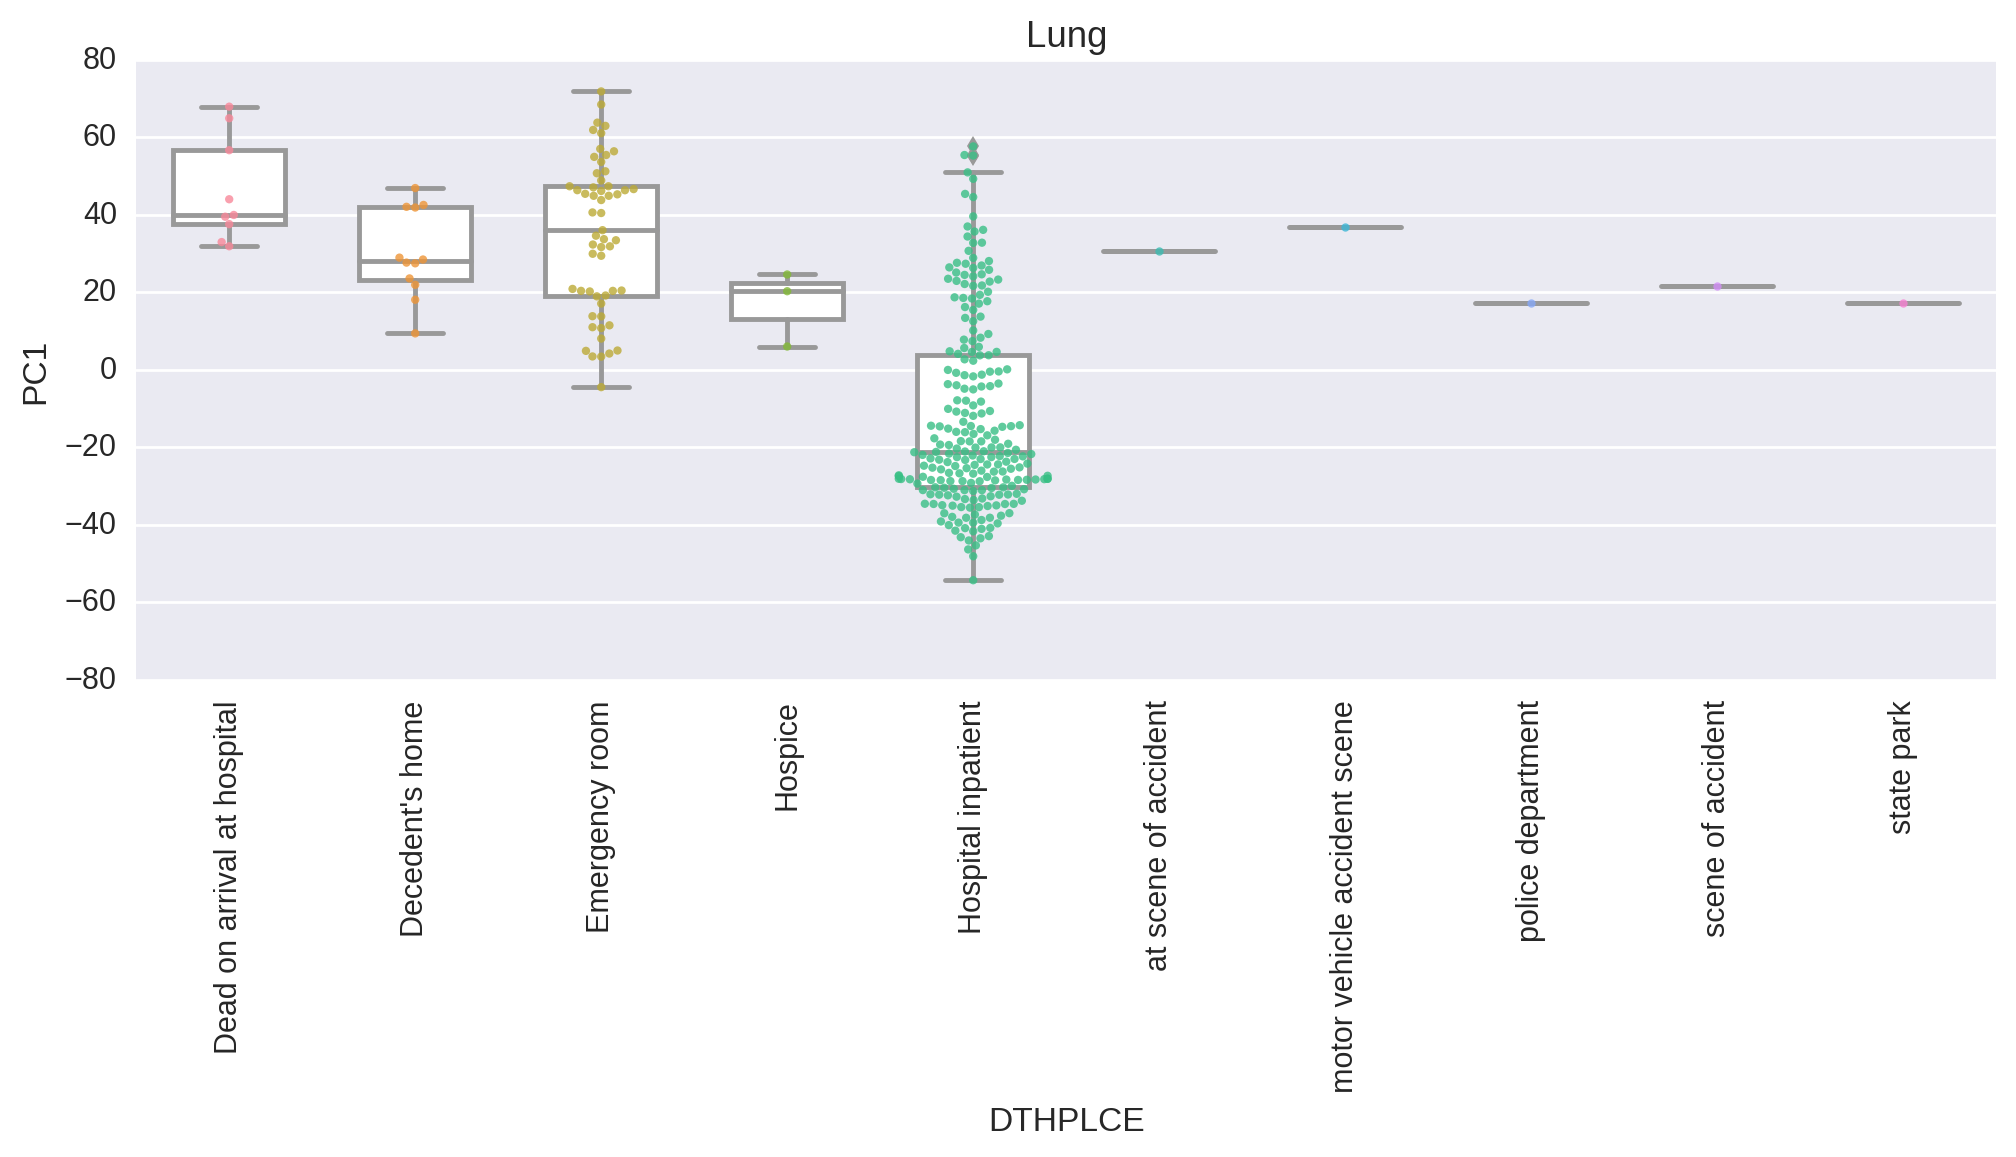

In [14]:
plot_pc_vs_covariate(df, 'Lung', 'PC1', 'DTHPLCE', rotate=True)

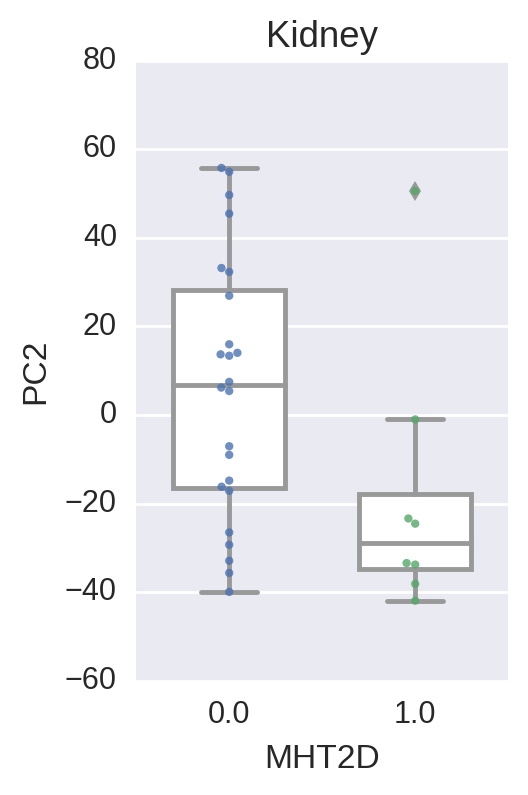

In [15]:
plot_pc_vs_covariate(df, 'Kidney', 'PC2', 'MHT2D')

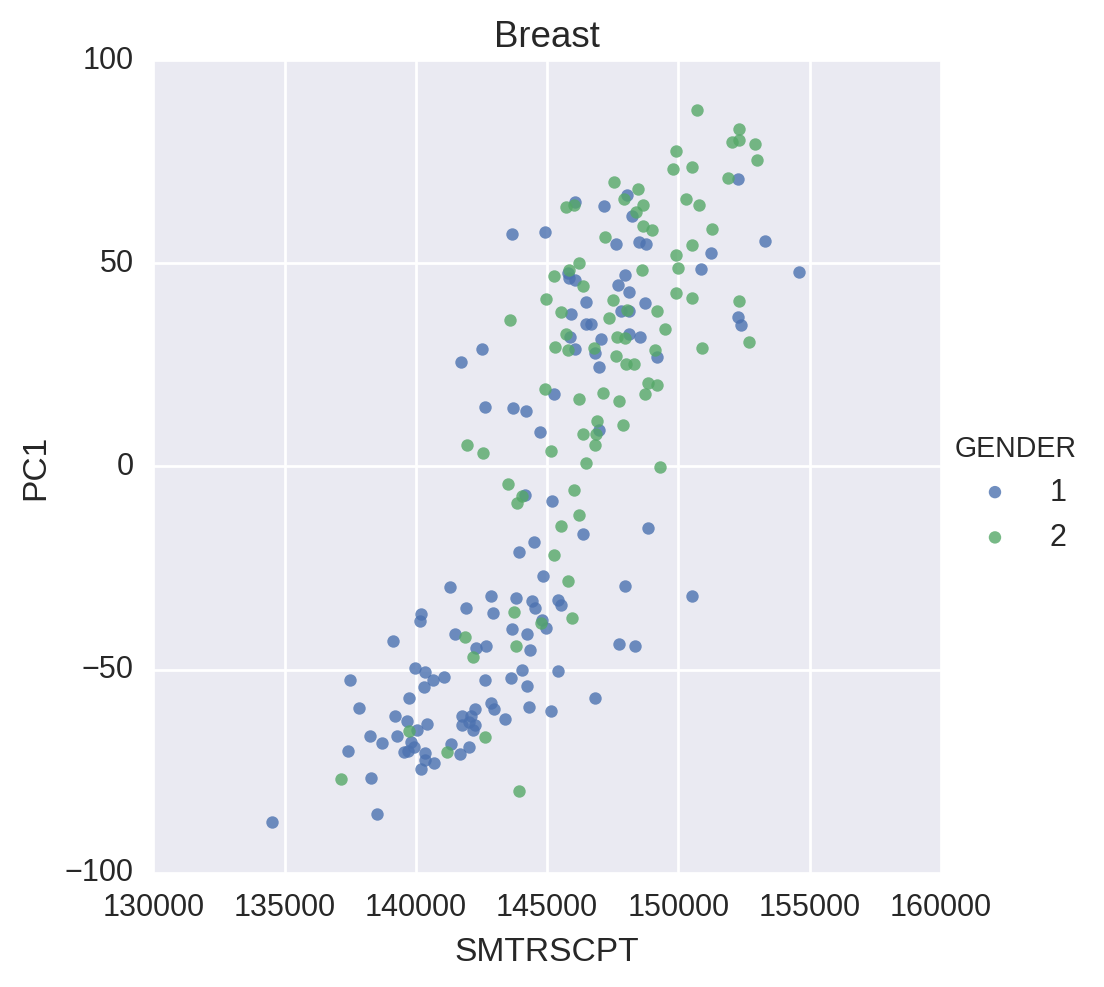

In [16]:
plot_pc_vs_covariate(df, 'Breast', 'PC1', 'SMTRSCPT', hue='GENDER', fit_reg=False)

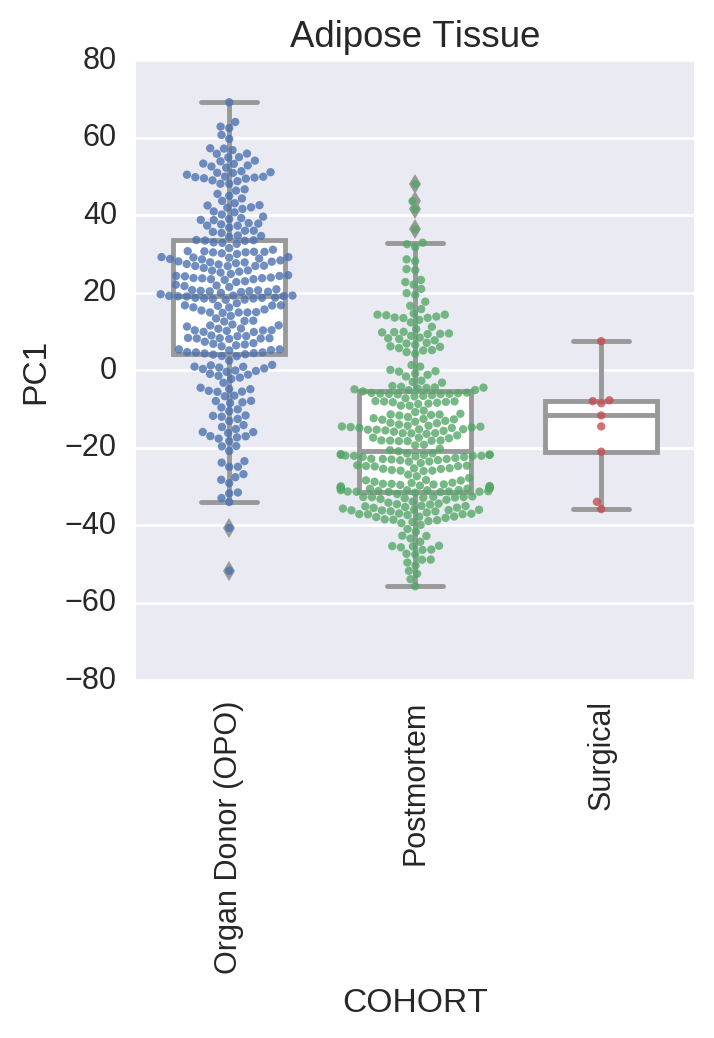

In [18]:
plot_pc_vs_covariate(df, 'Adipose Tissue', 'PC1', 'COHORT', rotate=True)

# Find non-linear relationships

In [61]:
INPUT = "../reports/Tissue-specific_MI_between_PCs_and_covariates.xlsx"
OUTPUT = "../reports/Nonlinear_PCR.xlsx"

with pd.ExcelFile(INPUT) as fin, pd.ExcelWriter(OUTPUT) as fout:
    for tissue in df.SMTS.cat.categories:
        subdf = df[df.SMTS == tissue]
        corr = subdf.corr().abs()
        cols = corr.columns
        df2 = pd.read_excel(fin, tissue).loc[cols, cols]
        df3 = ((df2 > corr) & (df2 > 0.05)).iloc[:, :10]
        df3.to_excel(fout, sheet_name=tissue)

# Heatmap for MI between PCs and covariates

In [112]:
def plot_MI_heatmap(VAR):
    D = {}
    with pd.ExcelFile(INPUT) as fin:
        for tissue in df.SMTS.cat.categories:
            df2 = pd.read_excel(fin, tissue)
            if VAR in df2.index:
                D[tissue] = df2.loc[VAR][:10]
    
    if D:
        mat = pd.DataFrame(D).T
        sns.heatmap(mat, linewidths=1)
        #sns.clustermap(mat, linewidths=1, col_cluster=False)
        plt.title(VAR)
        return mat

In [117]:
import os.path
OUTDIR = "../plots/PC_vs_covariates.heatmaps/"
for i in df.columns[177:]:
    if i in ['SMTS']: continue
    mat = plot_MI_heatmap(i)
    plt.savefig(os.path.join(OUTDIR, "%s.png" % i), bbox_inches='tight', dpi=300)
    plt.close()
    print i,

MHPRCNP MHPRKNSN MHPSBLDCLT MHRA MHRBSANML MHREYES MHRNLFLR MHSARS MHSCHZ MHSCLRDRM MHSDRGABS MHSEPSIS MHSKNSPT MHSMLPXCT MHSMLPXVC MHSRC MHSRCDSS MHSRGHM MHSTD MHSTRDLT MHSUBABSA MHSUBABSB MHSXMDA MHSXMDB MHSYPH12M MHSZRSU MHT1D MHT2D MHTBHX MHTEMPU MHTTOO12M MHTTOONP MHTXCEXP MHUK8096 MHUREMIA MHWKNSSU MHWNVCT MHWNVHX MHWTLSUA MHWTLSUB


## Gallery

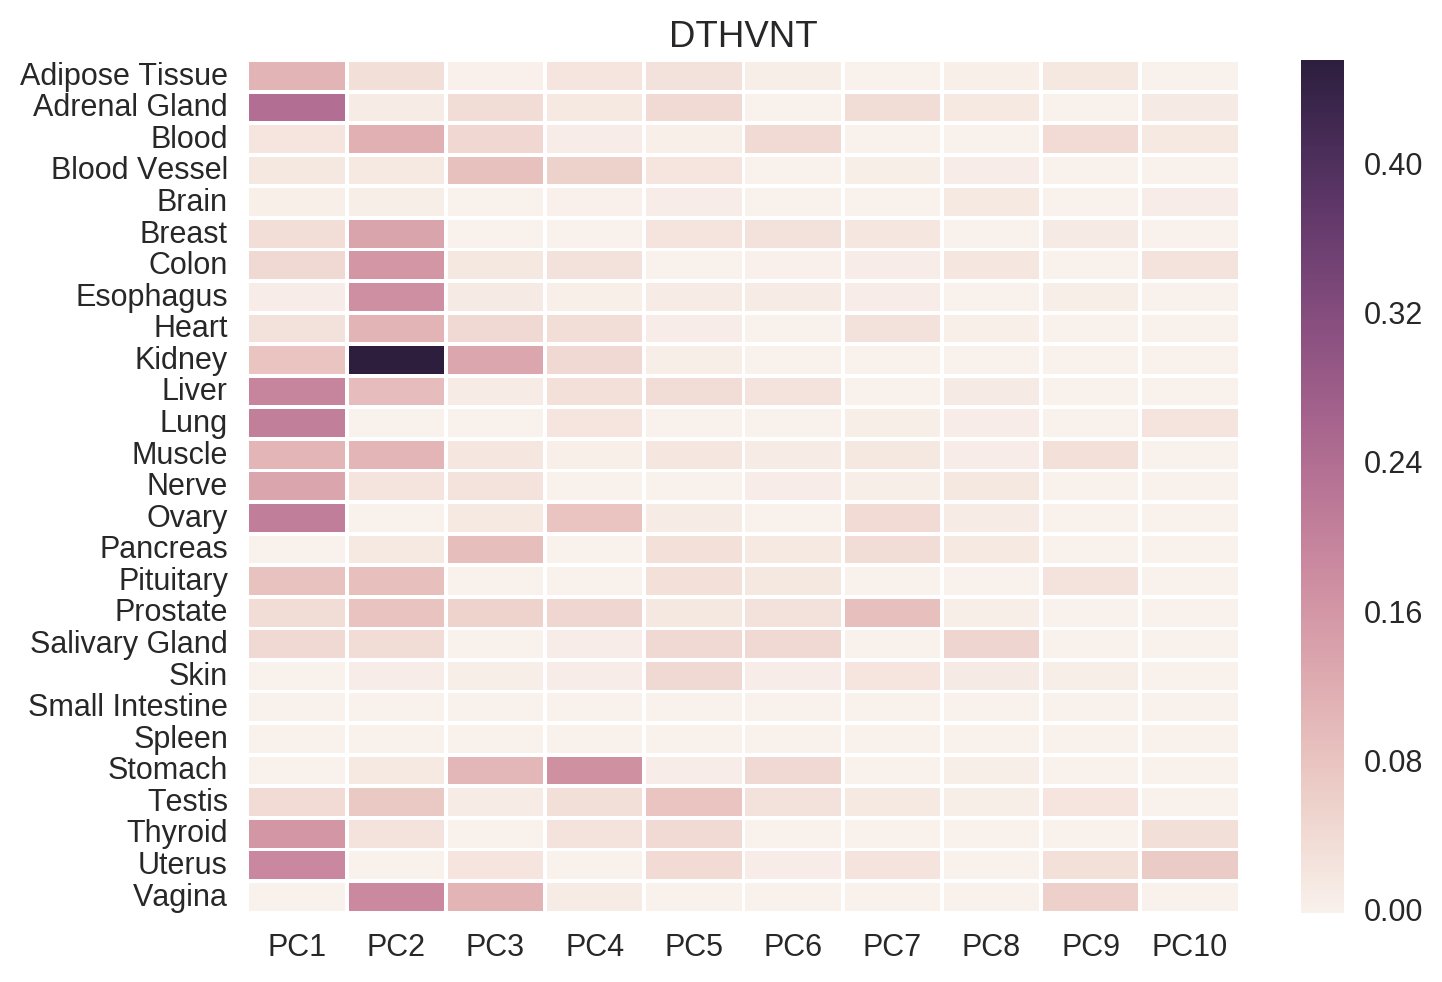

In [92]:
mat = plot_MI_heatmap('DTHVNT')  # Donor On A Ventilator Immediately Prior To Death

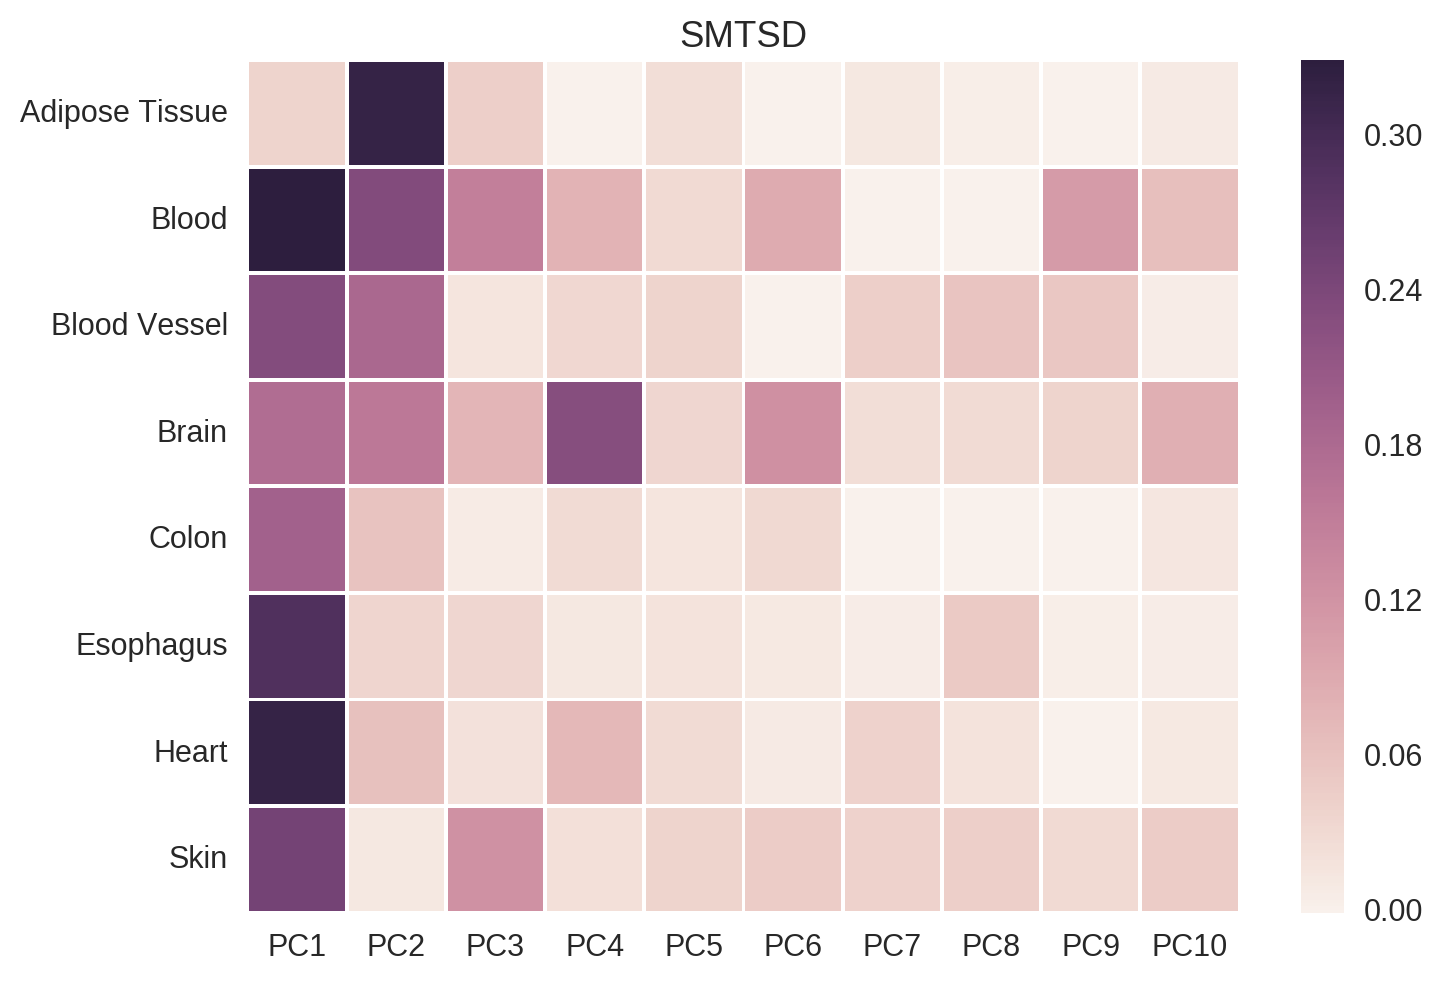

In [91]:
mat = plot_MI_heatmap('SMTSD')  # Tissue Type, area from which the tissue sample was taken. This is a parent value to SMTSD.

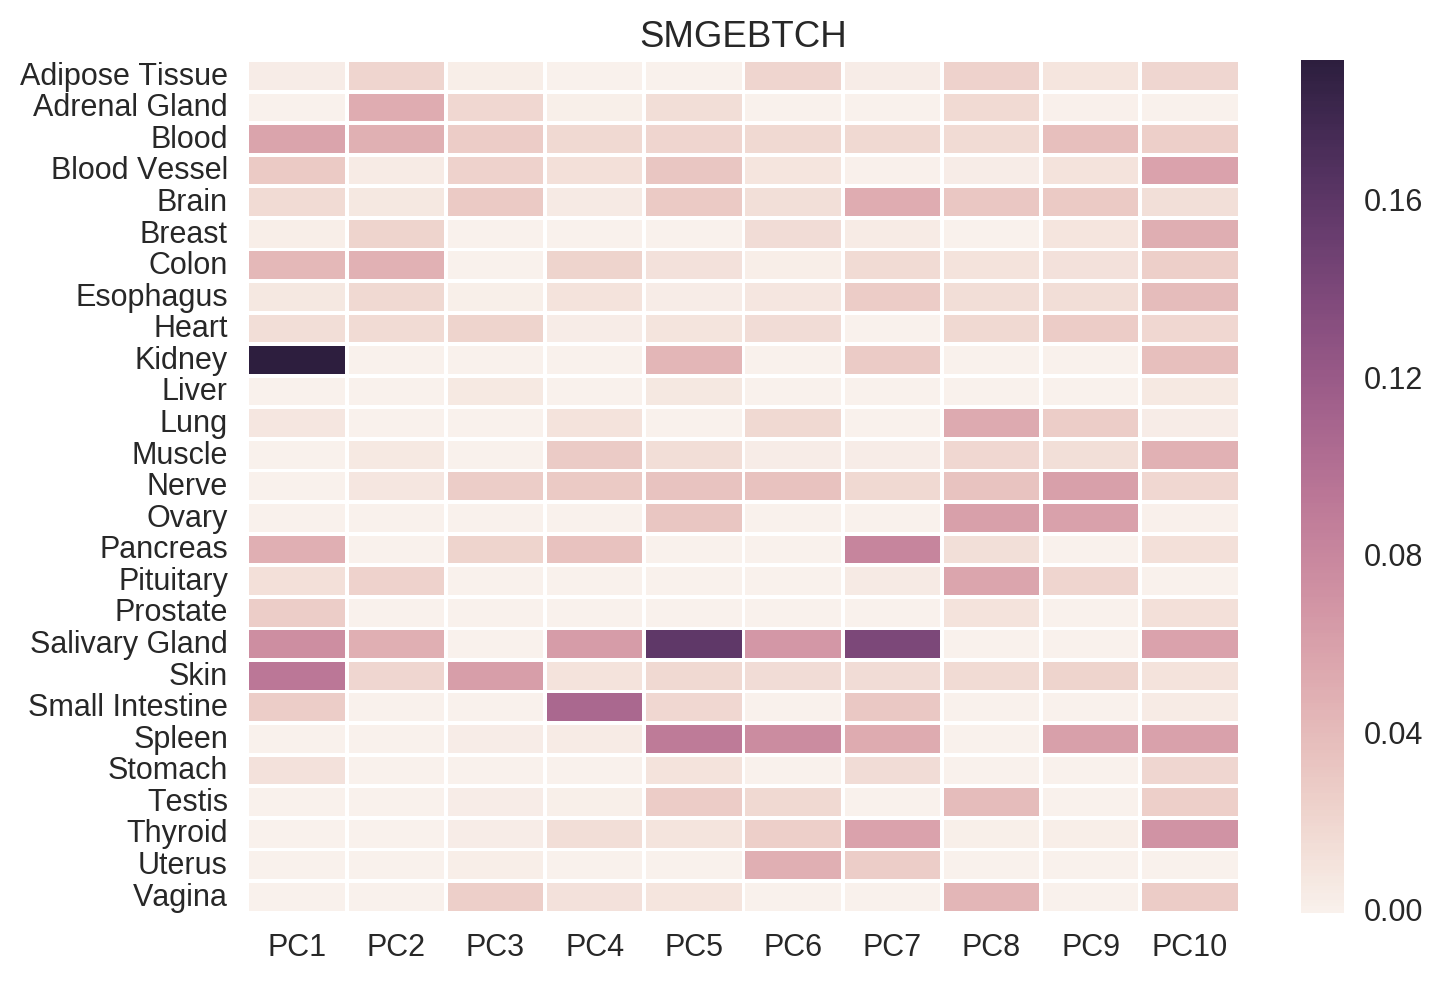

In [90]:
mat = plot_MI_heatmap('SMGEBTCH')  # Genotype or Expression Batch ID

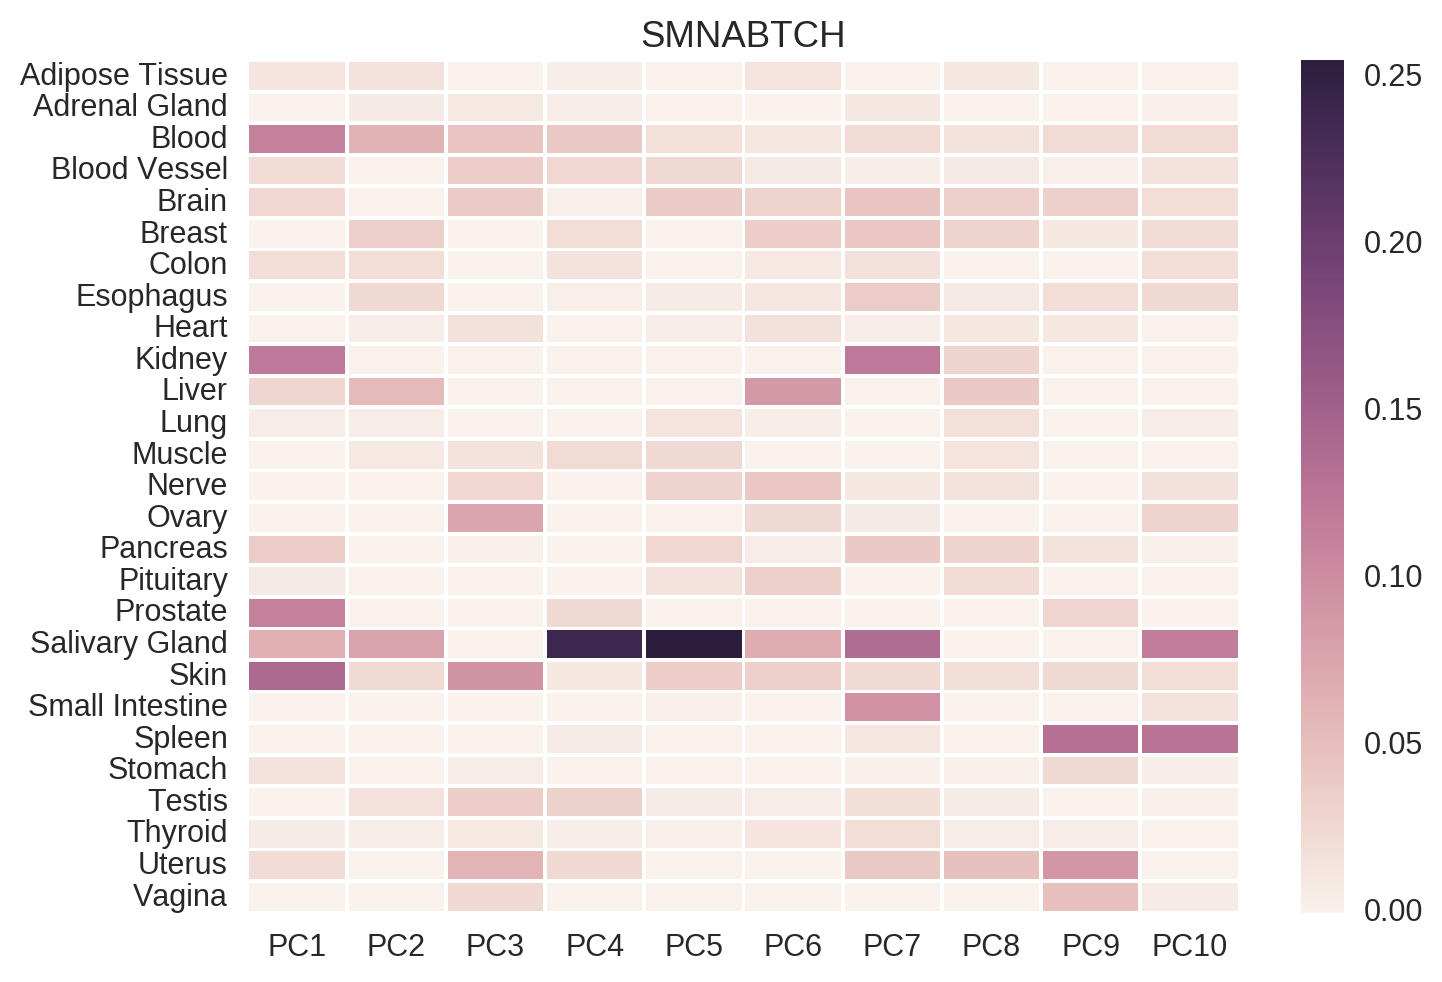

In [95]:
mat = plot_MI_heatmap('SMNABTCH')  # Nucleic Acid Isolation Batch ID

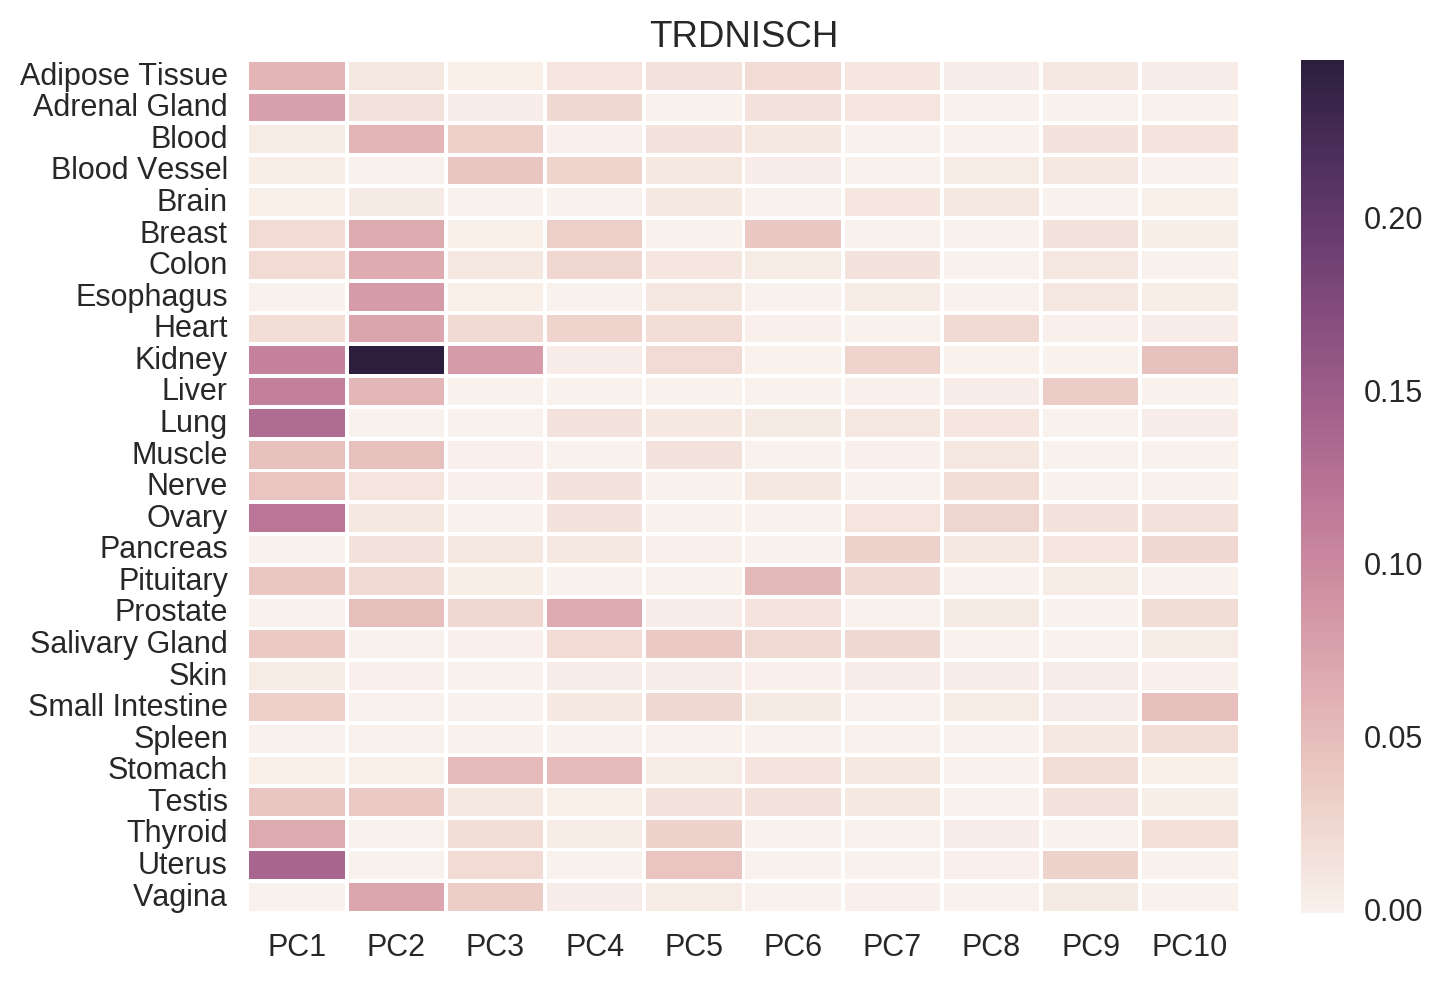

In [89]:
mat = plot_MI_heatmap('TRDNISCH')  # Total Ischemic time for a donor

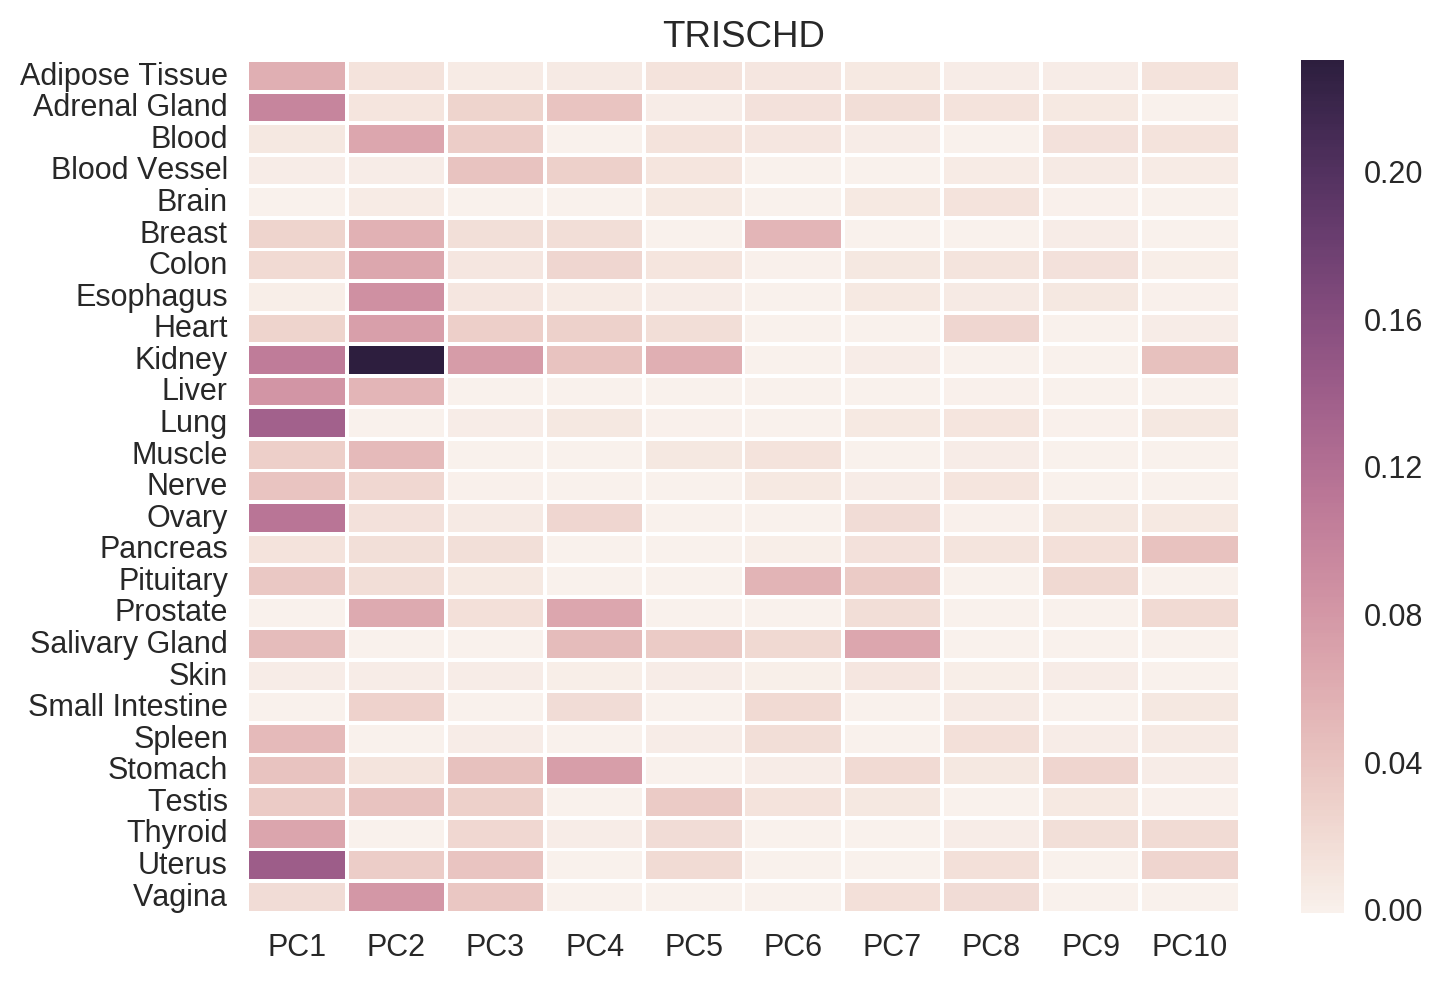

In [88]:
mat = plot_MI_heatmap('TRISCHD')  # Ischemic Time (Minutes)

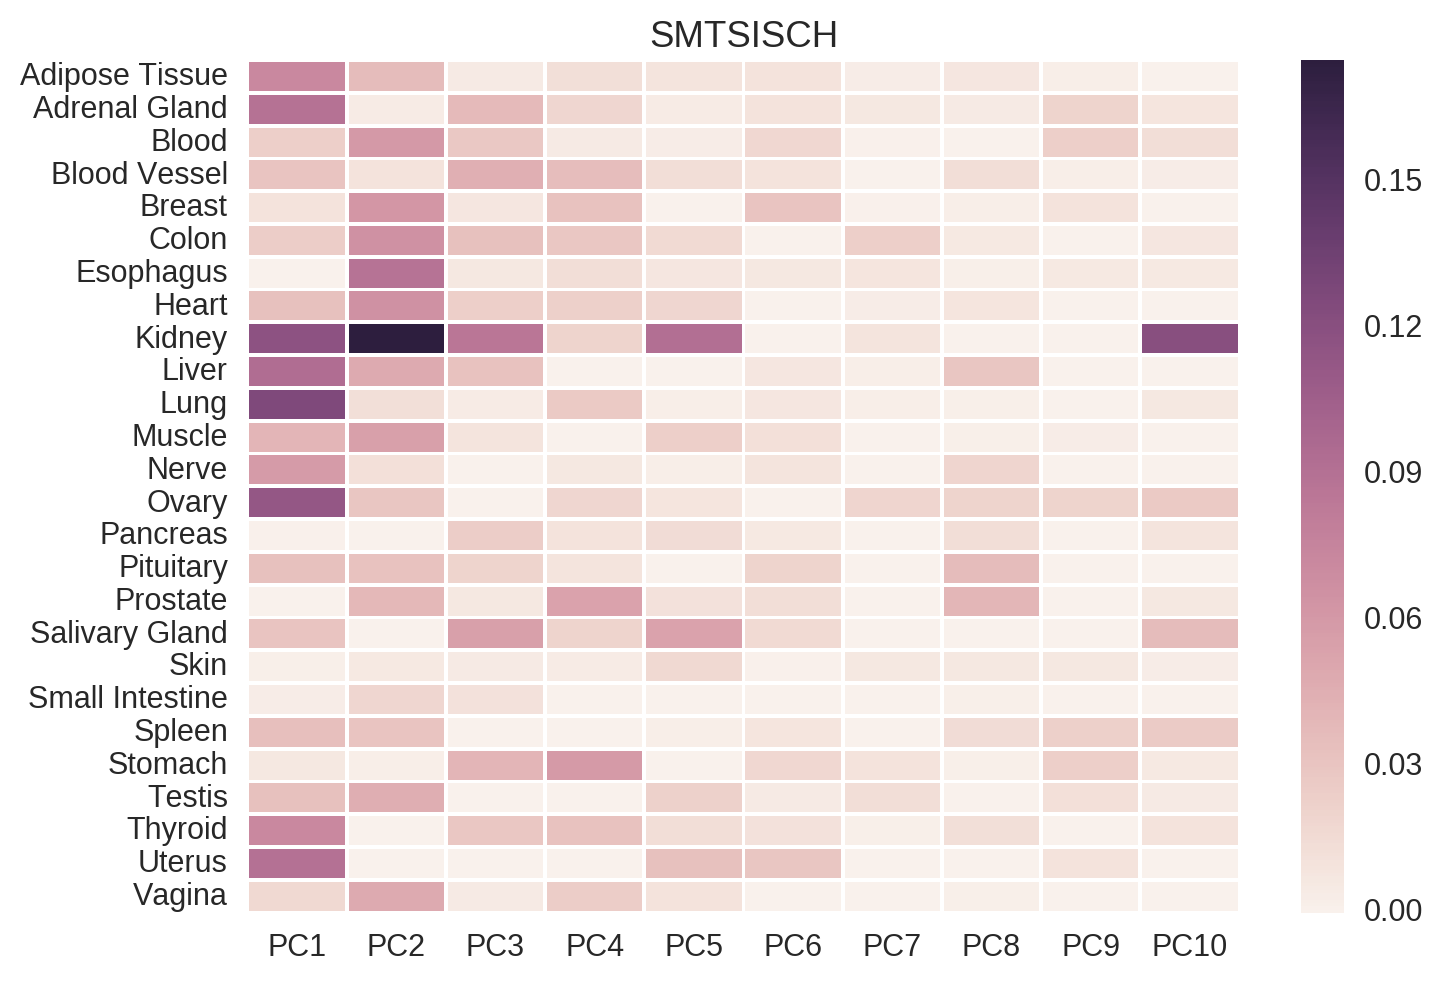

In [93]:
mat = plot_MI_heatmap('SMTSISCH')  # Total Ischemic time for a sample

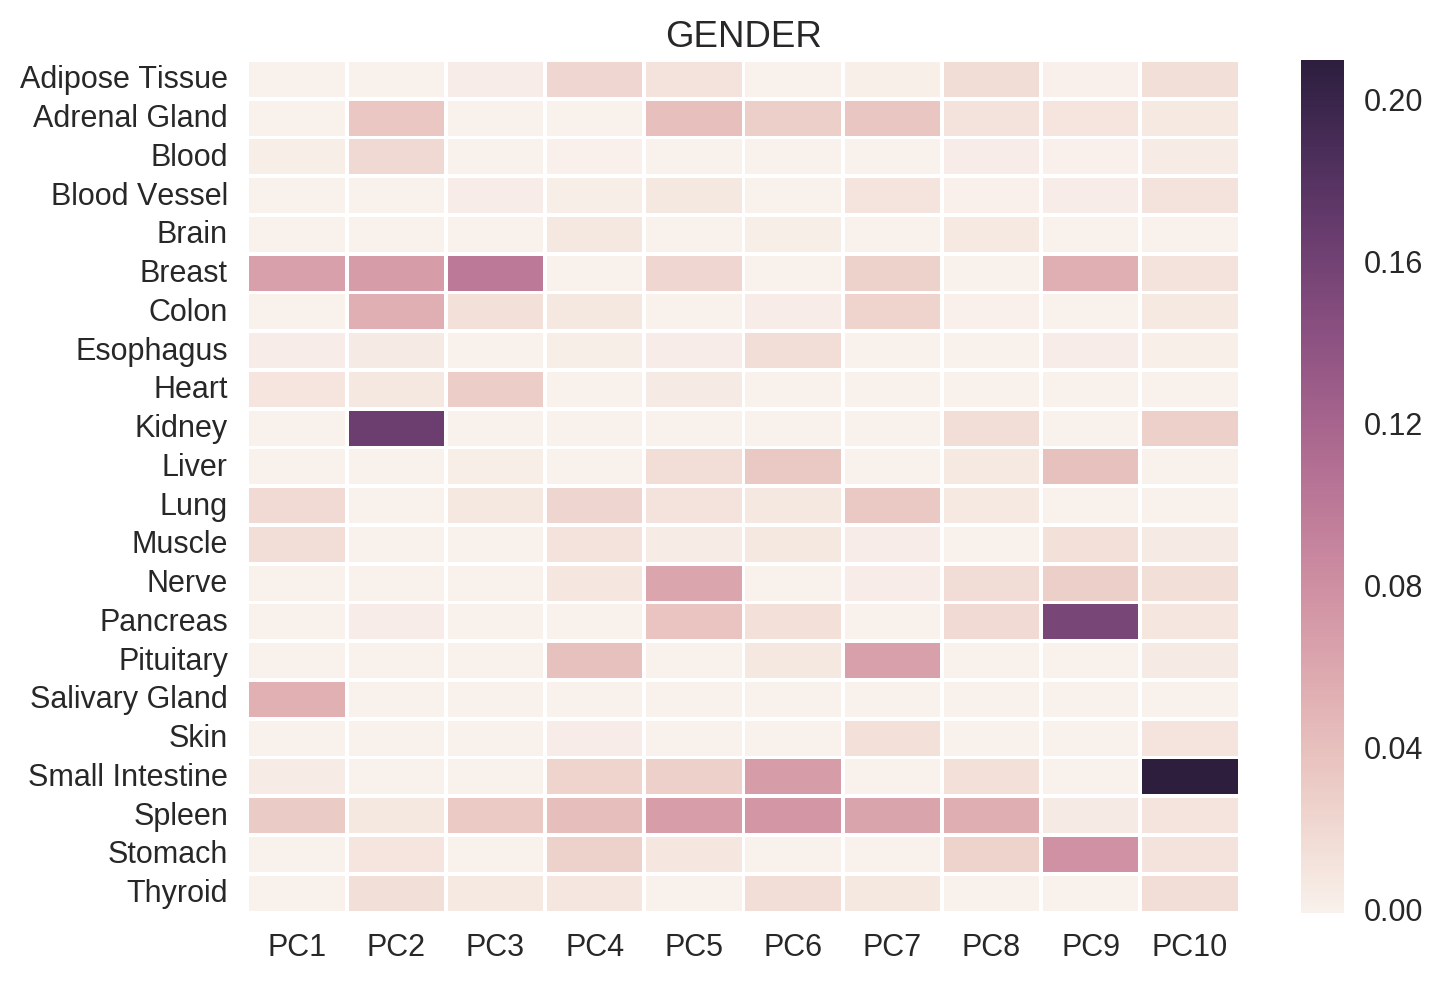

In [94]:
mat = plot_MI_heatmap('GENDER')